In [1]:
import numpy as np
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, mono_beta
import utils.plotting as plotting
from utils.eval import eval_predictions

2026-01-18 14:49:56.005355: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-18 14:49:56.446039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-18 14:49:58.079141: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1768758600.212365   31764 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1768758600.304442   31764 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
t_0, t_f, N = 0, 52, 100 
nop_data = t_f + 1
S0, I0, R0 = 99, 1, 0
noise_std = 0
test_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(mono_beta, 
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(test_t)
sir_data = rkdata.generate(test_t, noise_std)

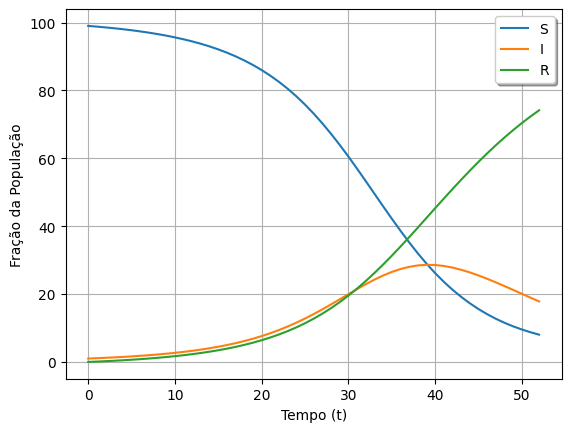

In [3]:
plotting.plot_rk_curves(test_t, sir_real)

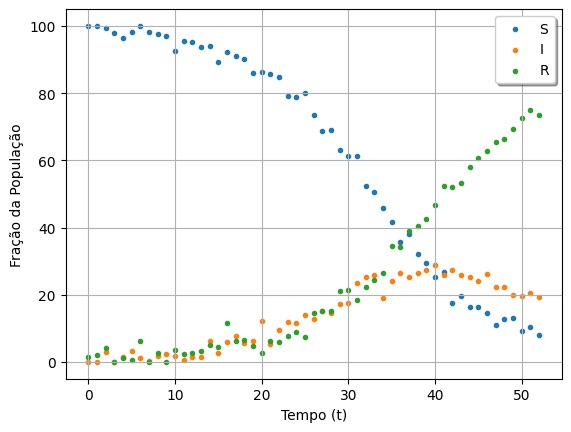

In [4]:
plotting.plot_rk_data(test_t, sir_data)

In [5]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], test_t,
    N=N,
    hidden_layer_size=50,
    n_hidden_layers=4,
    w_physics=30,
    scaling="norm",
    early_stopping=False,
    beta_hard_constraints=False,
    adaptative_wdata=False,
    fine_tunning_using_lbfgs=False)
model.S0, model.I0

Compiling model...
'compile' took 0.007002 s



(np.float64(1.0), np.float64(0.0))

In [6]:
model.train()

(<deepxde.model.LossHistory at 0x7f70dfb1ced0>,
 <deepxde.model.TrainState at 0x7f70dfb01f50>)

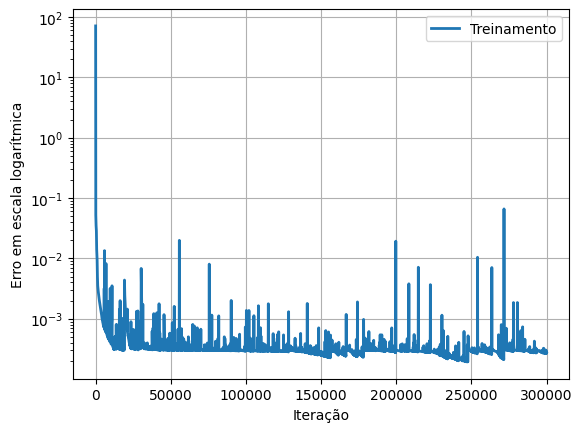

In [7]:
plotting.plot_losshistory(model.losshistory)

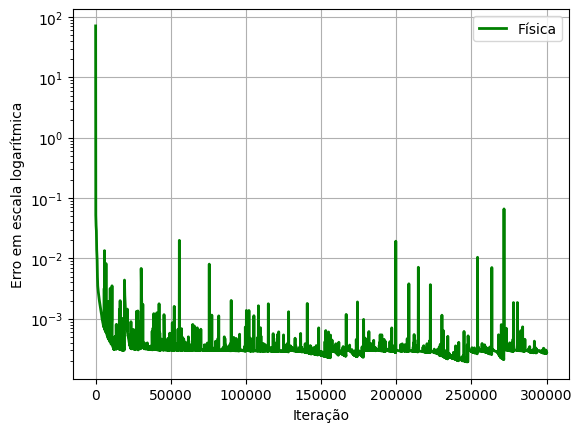

In [8]:
plotting.plot_phys_losshistory(model.losshistory)

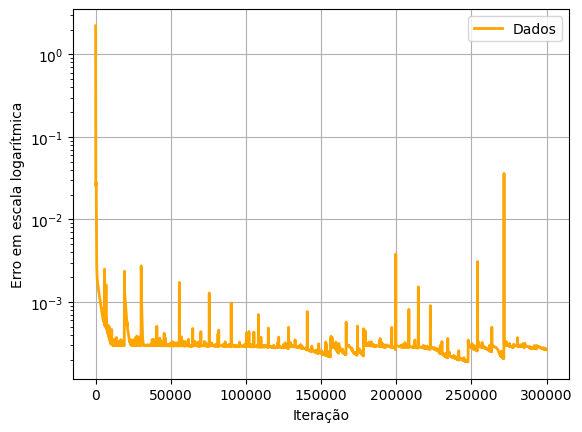

In [9]:
plotting.plot_data_losshistory(model.losshistory)

In [10]:
predictions = model.predict(test_t)

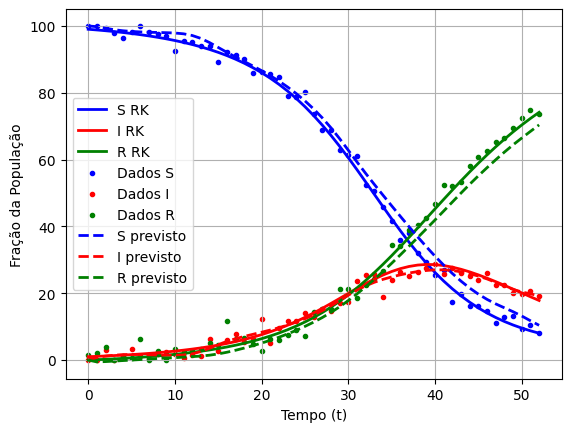

In [11]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N)

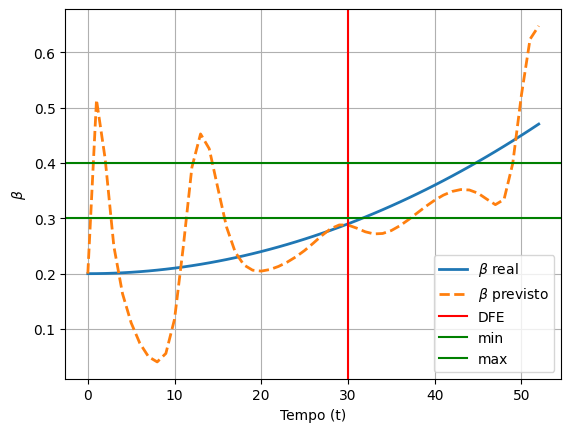

In [12]:
real_beta = mono_beta(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t, 
    vlines=[(30, "DFE", "red")], 
    hlines=[(0.3, "min", "green"), (0.4, "max", "green")])

In [13]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [14]:
real_values = stack_real_values(sir_real, real_beta)
predictions = eval_predictions(real_values, predictions)

In [15]:
predictions

,compartiment,RMSE,L2,L-infinity
0,S,2.838959,0.040281,4.903801
1,I,0.920885,0.052899,1.965398
2,beta,0.099297,0.328363,0.314254


In [16]:
predictions.to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n & compartiment & RMSE & L2 & L-infinity \\\\\n\\midrule\n0 & S & 2.838959 & 0.040281 & 4.903801 \\\\\n1 & I & 0.920885 & 0.052899 & 1.965398 \\\\\n2 & beta & 0.099297 & 0.328363 & 0.314254 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [17]:
model.formated_total_training_time

'00:07:37'